## Setup

In [8]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral


# load dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

model = None
modelName = 'model_conv2D'

greyscale = True
augmentation = True

# Number of augmentations per image
num_augmentations = 3

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Number of images in each class
print('Number of training images in each class:')
for c in classes:
    path = os.path.join(train_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
print('\nNumber of test images in each class:')
for c in classes:
    path = os.path.join(test_dir, c)
    print(f'{c}: {len(os.listdir(path))} images')
    
# Image size
img = cv2.imread('dataset/train/angry/Training_3908.jpg')
print(f'\nImage size: {img.shape}')

input_shape = img.shape

# Reduce image size to 48x48 pixels due to greyscale (original size: 48x48x3)
input_shape = (48, 48, 1)

Number of training images in each class:
angry: 6073 images
disgust: 659 images
fear: 6178 images
happy: 11045 images
sad: 7353 images
surprise: 4583 images
neutral: 7589 images

Number of test images in each class:
angry: 1459 images
disgust: 156 images
fear: 1527 images
happy: 2694 images
sad: 1889 images
surprise: 1134 images
neutral: 1901 images

Image size: (48, 48, 3)


## Preparing different models

In [23]:
# CNN MODEL
input_layer = tf.keras.layers.Input(shape=input_shape)

# Erster konventioneller Convolutional Pfad
conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(input_layer)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.ReLU()(conv1)
conv1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
dropout1 = tf.keras.layers.Dropout(0.2)(conv1)

# Zweiter konventioneller Convolutional Pfad
conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(dropout1)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.ReLU()(conv2)
conv2 = tf.keras.layers.MaxPooling2D(2, 2)(conv2)
dropout2 = tf.keras.layers.Dropout(0.2)(conv2)

# Dritter konventioneller Convolutional Pfad
conv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(conv2)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv3)
conv3 = tf.keras.layers.MaxPooling2D(2, 2)(conv3)
dropout3 = tf.keras.layers.Dropout(0.2)(conv3)

# Vierter konventioneller Convolutional Pfad
conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(dropout3)
conv4 = tf.keras.layers.BatchNormalization()(conv4)
conv4 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv4)
conv4 = tf.keras.layers.MaxPooling2D(2, 2)(conv4)
dropout4 = tf.keras.layers.Dropout(0.2)(conv4)

# Fünfter konventioneller Convolutional Pfad
conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(dropout4)
conv5 = tf.keras.layers.BatchNormalization()(conv5)
conv5 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(conv5)
conv5 = tf.keras.layers.MaxPooling2D(2, 2)(conv5)
dropout5 = tf.keras.layers.Dropout(0.2)(conv5)

# Paralleler Pfad mit Dilated Convolutions
# dilated1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', dilation_rate=3)(input_layer)
# dilated1 = tf.keras.layers.BatchNormalization()(dilated1)
# dilated1 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated1)
# dilated1 = tf.keras.layers.MaxPooling2D(2, 2)(dilated1)
# dropout1dilated = tf.keras.layers.Dropout(0.3)(dilated1)

# dilated2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', dilation_rate=3)(dropout1dilated)
# dilated2 = tf.keras.layers.BatchNormalization()(dilated2)
# dilated2 = tf.keras.layers.LeakyReLU(negative_slope=0.001)(dilated2)
# dilated2 = tf.keras.layers.MaxPooling2D(2, 2)(dilated2)
# dropout2dilated = tf.keras.layers.Dropout(0.3)(dilated2)

# dilated3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', dilation_rate=4)(dilated2)
# dilated3 = tf.keras.layers.BatchNormalization()(dilated3)
# dilated3 = tf.keras.layers.LeakyReLU(negative_slope=0.01)(dilated3)
# dilated3 = tf.keras.layers.MaxPooling2D(2, 2)(dilated3)

# Zusammenführung der Pfade
merged = tf.keras.layers.concatenate([dropout5])

# Flatten und Dense Layers
flat = tf.keras.layers.Flatten()(merged)
dense1 = tf.keras.layers.Dense(512)(flat)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.ReLU()(dense1)
dropout = tf.keras.layers.Dropout(0.3)(dense1)
output = tf.keras.layers.Dense(7, activation='softmax')(dropout)

# Modell definieren
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 531,527 (2.03 MB)

 Trainable params: 529,511 (2.02 MB)

 Non-trainable params: 2,016 (7.88 KB)

## Loading the images from disk

In [12]:
def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1] range
    return img

# Load the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',  # Integer-Labels
    image_size=(48, 48),
    batch_size=64,
    color_mode='grayscale' if greyscale else 'rgb',
)

# Normalize the images to [0,1]
train_ds = train_ds.map(lambda img, label: (normalize_image(img), label))
test_ds = test_ds.map(lambda img, label: (normalize_image(img), label))

# One-Hot-Encoding of the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

num_classes = 7

train_ds = train_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

Found 43479 files belonging to 7 classes.
Found 10764 files belonging to 7 classes.


In [13]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_contrast(img, lower=0.6, upper=1.4)
    # Some augmentations are only applicable to RGB images
    if not greyscale:
        img = tf.image.random_hue(img, max_delta=0.2)
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    return img, label

def augment_multiple(img, label, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    for _ in range(num_augmentations):
        augmented_img, augmented_label = augment(img, label)
        augmented_images.append(augmented_img)
        augmented_labels.append(augmented_label)
    return tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Augment the training data
if augmentation:
    augmented_datasets = train_ds.flat_map(lambda img, label: augment_multiple(img, label, num_augmentations))
    train_ds = train_ds.concatenate(augmented_datasets)

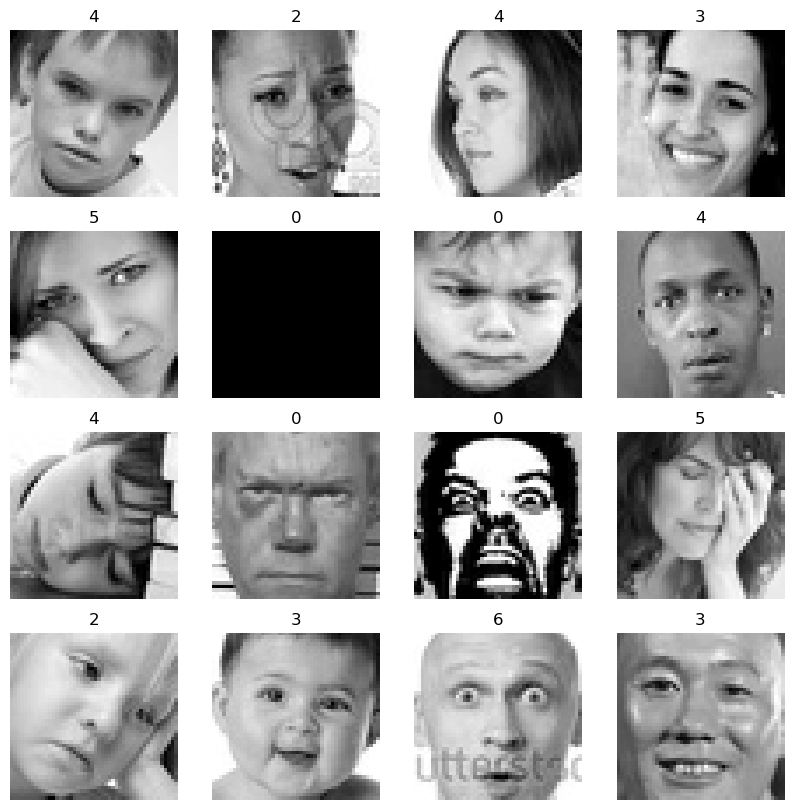

2024-07-09 10:41:56.952244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        if greyscale:
            plt.imshow(np.squeeze(images[i]), cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    plt.show()


Image shape: (64, 48, 48, 1), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


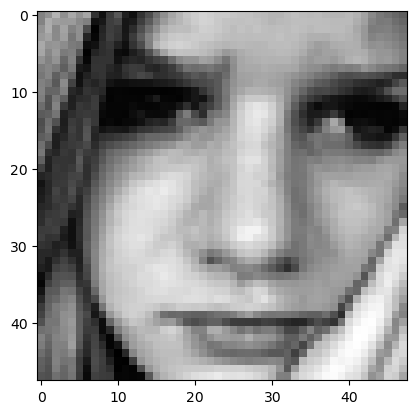

2024-07-09 10:41:57.034063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")
    
    # Plot the image
    if greyscale:
        plt.imshow(np.squeeze(img[0]), cmap='gray')
    else:
        plt.imshow(img[0])
    plt.show()

## Class distribution and weights

In [16]:
import collections

def get_class_distribution(dataset):
    class_counts = collections.Counter()
    
    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())
    
    return class_counts

# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


2024-07-09 10:42:23.652111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Class Distribution: Counter({3: 44180, 4: 30356, 5: 29412, 2: 24708, 0: 24292, 6: 18332, 1: 2636})
Test Class Distribution: Counter({3: 2694, 4: 1903, 5: 1889, 2: 1527, 0: 1461, 6: 1134, 1: 156})


2024-07-09 10:42:25.803771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
import sklearn
from sklearn.utils import class_weight

# Load test data
x_train = []
y_train = []

for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        # img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            # img = cv2.resize(img, (48, 48))
            # x_train.append(img)
            y_train.append(i)

In [18]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0227941003504974, 1: 9.425536527205724, 2: 1.0054109050548028, 3: 0.56237470089892, 4: 0.8447475277340638, 5: 1.3553193479006265, 6: 0.8184778721081264}
Type of keys: <class 'int'>
Type of values: <class 'float'>


# Custom Callbacks

In [19]:
# Callback function to print the best value of a metric (to roughly predict when the training will finish due to early stopping)
class RecordMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric='val_loss', mode='min'):
        super(RecordMetricCallback, self).__init__()
        self.metric = metric
        self.mode = mode
        self.best_epoch = -1
        self.best_value = None
        if mode == 'min':
            self.best_value = float('inf')
        elif mode == 'max':
            self.best_value = -float('inf')
        else:
            raise ValueError("Mode must be 'min' or 'max'")

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.metric)
        if current_value is not None:
            if (self.mode == 'min' and current_value < self.best_value) or (self.mode == 'max' and current_value > self.best_value):
                self.best_value = current_value
                self.best_epoch = epoch
            print(f'Best {self.metric} so far: {self.best_value:.3f} (Epoch {self.best_epoch + 1})')

# Callbacks

In [25]:
metric = 'val_accuracy'
mode = 'max'

# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(monitor=metric, patience=25, restore_best_weights=True, mode=mode)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=metric, factor=0.2, patience=5, min_lr=1e-7, mode=mode)
record_val_accuracy = RecordMetricCallback(metric=metric, mode=mode)

In [21]:
for image, label in train_ds.take(1):  # Only take the first batch
    print(label[0])  # Show the label

tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)


2024-07-09 10:43:34.954576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training & Evaluation

In [26]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=5000,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping, record_val_accuracy],
)

Epoch 1/5000
   2715/Unknown 17s 6ms/step - accuracy: 0.4894 - loss: 1.3454

2024-07-09 10:49:17.210781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:49:17.210818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.44082126021385193 (Epoch 1)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4894 - loss: 1.3454 - val_accuracy: 0.4408 - val_loss: 1.4457 - learning_rate: 0.0010
Epoch 2/5000
2714/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5254 - loss: 1.2366

2024-07-09 10:49:35.880690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:49:35.880732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5305648446083069 (Epoch 2)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.5254 - loss: 1.2366 - val_accuracy: 0.5306 - val_loss: 1.2530 - learning_rate: 0.0010
Epoch 3/5000
2715/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5580 - loss: 1.1406

2024-07-09 10:49:54.194071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:49:54.194111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5305648446083069 (Epoch 2)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5580 - loss: 1.1406 - val_accuracy: 0.5181 - val_loss: 1.2736 - learning_rate: 0.0010
Epoch 4/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5793 - loss: 1.0734

2024-07-09 10:50:12.044593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:50:12.044640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5305648446083069 (Epoch 2)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5793 - loss: 1.0734 - val_accuracy: 0.5093 - val_loss: 1.3002 - learning_rate: 0.0010
Epoch 5/5000
2710/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5963 - loss: 1.0231

2024-07-09 10:50:30.022575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:50:30.022608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5515607595443726 (Epoch 5)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5963 - loss: 1.0231 - val_accuracy: 0.5516 - val_loss: 1.2309 - learning_rate: 0.0010
Epoch 6/5000
2717/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6141 - loss: 0.9783

2024-07-09 10:50:48.122709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:50:48.122755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5528613924980164 (Epoch 6)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6141 - loss: 0.9783 - val_accuracy: 0.5529 - val_loss: 1.1922 - learning_rate: 0.0010
Epoch 7/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6285 - loss: 0.9369

2024-07-09 10:51:06.614219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:51:06.614250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-07-09 10:51:06.614255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9988427460149596739
2024-07-09 10:51:06.614258: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:51:06.614271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16748503773323223558


Best val_accuracy so far: 0.585934579372406 (Epoch 7)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6285 - loss: 0.9370 - val_accuracy: 0.5859 - val_loss: 1.1422 - learning_rate: 0.0010
Epoch 8/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6389 - loss: 0.9087

2024-07-09 10:51:24.950598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:51:24.950630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5948532223701477 (Epoch 8)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6389 - loss: 0.9088 - val_accuracy: 0.5949 - val_loss: 1.1081 - learning_rate: 0.0010
Epoch 9/5000
2716/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6509 - loss: 0.8816

2024-07-09 10:51:43.113857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:51:43.113898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5948532223701477 (Epoch 8)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6509 - loss: 0.8816 - val_accuracy: 0.5857 - val_loss: 1.1519 - learning_rate: 0.0010
Epoch 10/5000
2707/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6628 - loss: 0.8512

2024-07-09 10:52:01.824593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:52:01.824634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5948532223701477 (Epoch 8)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6627 - loss: 0.8513 - val_accuracy: 0.5735 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 11/5000
2717/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6723 - loss: 0.8309

2024-07-09 10:52:20.748415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:52:20.748469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5948532223701477 (Epoch 8)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6723 - loss: 0.8309 - val_accuracy: 0.5587 - val_loss: 1.2183 - learning_rate: 0.0010
Epoch 12/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6836 - loss: 0.7987

2024-07-09 10:52:38.748774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:52:38.748814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.5948532223701477 (Epoch 8)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6836 - loss: 0.7988 - val_accuracy: 0.5674 - val_loss: 1.2096 - learning_rate: 0.0010
Epoch 13/5000
2714/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6908 - loss: 0.7795

2024-07-09 10:52:57.442321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:52:57.442359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6065589189529419 (Epoch 13)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6908 - loss: 0.7796 - val_accuracy: 0.6066 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 14/5000
2716/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6985 - loss: 0.7643

2024-07-09 10:53:16.548476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:53:16.548511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-07-09 10:53:16.548516: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9988427460149596739
2024-07-09 10:53:16.548518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:53:16.548533: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16748503773323223558


Best val_accuracy so far: 0.6065589189529419 (Epoch 13)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6985 - loss: 0.7644 - val_accuracy: 0.5881 - val_loss: 1.1559 - learning_rate: 0.0010
Epoch 15/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7057 - loss: 0.7442

2024-07-09 10:53:35.695576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:53:35.695613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6065589189529419 (Epoch 13)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7056 - loss: 0.7443 - val_accuracy: 0.6043 - val_loss: 1.1355 - learning_rate: 0.0010
Epoch 16/5000
2719/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7127 - loss: 0.7269

2024-07-09 10:53:56.902705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:53:56.902779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6065589189529419 (Epoch 13)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7127 - loss: 0.7270 - val_accuracy: 0.5976 - val_loss: 1.1484 - learning_rate: 0.0010
Epoch 17/5000
2710/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7213 - loss: 0.7073

2024-07-09 10:54:20.838252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:54:20.838294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6065589189529419 (Epoch 13)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7213 - loss: 0.7074 - val_accuracy: 0.6027 - val_loss: 1.1465 - learning_rate: 0.0010
Epoch 18/5000
2716/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7257 - loss: 0.6983

2024-07-09 10:54:44.939808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:54:44.939846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6116685271263123 (Epoch 18)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7256 - loss: 0.6983 - val_accuracy: 0.6117 - val_loss: 1.1320 - learning_rate: 0.0010
Epoch 19/5000
2715/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7296 - loss: 0.6869

2024-07-09 10:55:08.027097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 10:55:08.027143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Best val_accuracy so far: 0.6116685271263123 (Epoch 18)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.7296 - loss: 0.6870 - val_accuracy: 0.5594 - val_loss: 1.2683 - learning_rate: 0.0010
Epoch 20/5000
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7332 - loss: 0.6790

2024-07-09 10:55:31.876735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:55:31.876770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6116685271263123 (Epoch 18)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7332 - loss: 0.6790 - val_accuracy: 0.5964 - val_loss: 1.1500 - learning_rate: 0.0010
Epoch 21/5000
2714/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7378 - loss: 0.6653

2024-07-09 10:55:54.633216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:55:54.633259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6116685271263123 (Epoch 18)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7377 - loss: 0.6654 - val_accuracy: 0.6057 - val_loss: 1.1497 - learning_rate: 0.0010
Epoch 22/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7444 - loss: 0.6468

2024-07-09 10:56:14.007593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:56:14.007658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6116685271263123 (Epoch 18)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7443 - loss: 0.6470 - val_accuracy: 0.5417 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 23/5000
2718/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7458 - loss: 0.6520

2024-07-09 10:56:33.105119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:56:33.105144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-07-09 10:56:33.105149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9988427460149596739
2024-07-09 10:56:33.105151: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:56:33.105167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16748503773323223558


Best val_accuracy so far: 0.6116685271263123 (Epoch 18)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7458 - loss: 0.6520 - val_accuracy: 0.6020 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 24/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7591 - loss: 0.6100

2024-07-09 10:56:52.339389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:56:52.339416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-07-09 10:56:52.339421: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9988427460149596739
2024-07-09 10:56:52.339423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:56:52.339437: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16748503773323223558


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7591 - loss: 0.6100 - val_accuracy: 0.6263 - val_loss: 1.1260 - learning_rate: 2.0000e-04
Epoch 25/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7721 - loss: 0.5802

2024-07-09 10:57:11.713263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:57:11.713297: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:57:11.713366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7721 - loss: 0.5803 - val_accuracy: 0.6246 - val_loss: 1.1331 - learning_rate: 2.0000e-04
Epoch 26/5000
2711/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7811 - loss: 0.5580

2024-07-09 10:57:30.608701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:57:30.608733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-07-09 10:57:30.608738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9988427460149596739
2024-07-09 10:57:30.608740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:57:30.608755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16748503773323223558


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7810 - loss: 0.5581 - val_accuracy: 0.6224 - val_loss: 1.1381 - learning_rate: 2.0000e-04
Epoch 27/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7824 - loss: 0.5564

2024-07-09 10:57:49.729482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 10:57:49.729519: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:57:49.729525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7824 - loss: 0.5566 - val_accuracy: 0.6259 - val_loss: 1.1393 - learning_rate: 2.0000e-04
Epoch 28/5000
2718/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7869 - loss: 0.5458

2024-07-09 10:58:08.811069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:58:08.811103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7869 - loss: 0.5458 - val_accuracy: 0.6250 - val_loss: 1.1426 - learning_rate: 2.0000e-04
Epoch 29/5000
2714/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7887 - loss: 0.5366

2024-07-09 10:58:27.582478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:58:27.582514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7886 - loss: 0.5367 - val_accuracy: 0.6194 - val_loss: 1.1696 - learning_rate: 2.0000e-04
Epoch 30/5000
2719/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7911 - loss: 0.5329

2024-07-09 10:58:46.274397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:58:46.274443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6263470649719238 (Epoch 24)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7911 - loss: 0.5329 - val_accuracy: 0.6258 - val_loss: 1.1521 - learning_rate: 4.0000e-05
Epoch 31/5000
2706/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7949 - loss: 0.5230

2024-07-09 10:59:04.586813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:59:04.586852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6266257762908936 (Epoch 31)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7948 - loss: 0.5232 - val_accuracy: 0.6266 - val_loss: 1.1611 - learning_rate: 4.0000e-05
Epoch 32/5000
2719/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7917 - loss: 0.5286

2024-07-09 10:59:22.843093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:59:22.843128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 10:59:22.843147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


Best val_accuracy so far: 0.6266257762908936 (Epoch 31)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7917 - loss: 0.5286 - val_accuracy: 0.6256 - val_loss: 1.1609 - learning_rate: 4.0000e-05
Epoch 33/5000
2710/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7960 - loss: 0.5212

2024-07-09 10:59:41.098055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:59:41.098098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6266257762908936 (Epoch 31)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7960 - loss: 0.5214 - val_accuracy: 0.6257 - val_loss: 1.1603 - learning_rate: 4.0000e-05
Epoch 34/5000
2706/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7956 - loss: 0.5201

2024-07-09 10:59:59.320875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 10:59:59.320914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6266257762908936 (Epoch 31)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7955 - loss: 0.5203 - val_accuracy: 0.6251 - val_loss: 1.1614 - learning_rate: 4.0000e-05
Epoch 35/5000
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7971 - loss: 0.5175

2024-07-09 11:00:17.671378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:00:17.671416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6270902752876282 (Epoch 35)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7971 - loss: 0.5175 - val_accuracy: 0.6271 - val_loss: 1.1655 - learning_rate: 4.0000e-05
Epoch 36/5000
2708/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7966 - loss: 0.5175

2024-07-09 11:00:35.933292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:00:35.933338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 11:00:35.933360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909


Best val_accuracy so far: 0.6270902752876282 (Epoch 35)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7966 - loss: 0.5176 - val_accuracy: 0.6266 - val_loss: 1.1646 - learning_rate: 4.0000e-05
Epoch 37/5000
2708/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7989 - loss: 0.5155

2024-07-09 11:00:54.194367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:00:54.194411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6270902752876282 (Epoch 35)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7988 - loss: 0.5157 - val_accuracy: 0.6260 - val_loss: 1.1654 - learning_rate: 4.0000e-05
Epoch 38/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8003 - loss: 0.5122

2024-07-09 11:01:12.489033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:01:12.489073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6282051205635071 (Epoch 38)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8003 - loss: 0.5123 - val_accuracy: 0.6282 - val_loss: 1.1674 - learning_rate: 4.0000e-05
Epoch 39/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8002 - loss: 0.5109

2024-07-09 11:01:33.557758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:01:33.557800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6282051205635071 (Epoch 38)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8002 - loss: 0.5110 - val_accuracy: 0.6273 - val_loss: 1.1692 - learning_rate: 4.0000e-05
Epoch 40/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8012 - loss: 0.5091

2024-07-09 11:01:57.209550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:01:57.209590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6282051205635071 (Epoch 38)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8011 - loss: 0.5092 - val_accuracy: 0.6282 - val_loss: 1.1706 - learning_rate: 4.0000e-05
Epoch 41/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8005 - loss: 0.5074

2024-07-09 11:02:20.405612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:02:20.405654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6282051205635071 (Epoch 38)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8005 - loss: 0.5075 - val_accuracy: 0.6281 - val_loss: 1.1684 - learning_rate: 4.0000e-05
Epoch 42/5000
2714/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8005 - loss: 0.5089

2024-07-09 11:02:44.317693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-09 11:02:44.317734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Best val_accuracy so far: 0.6282051205635071 (Epoch 38)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8005 - loss: 0.5090 - val_accuracy: 0.6272 - val_loss: 1.1663 - learning_rate: 4.0000e-05
Epoch 43/5000
2716/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8035 - loss: 0.5048

2024-07-09 11:03:08.691020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:03:08.691059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6286696195602417 (Epoch 43)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8035 - loss: 0.5049 - val_accuracy: 0.6287 - val_loss: 1.1694 - learning_rate: 4.0000e-05
Epoch 44/5000
2718/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8021 - loss: 0.5066

2024-07-09 11:03:32.671282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:03:32.671321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6286696195602417 (Epoch 43)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8021 - loss: 0.5066 - val_accuracy: 0.6268 - val_loss: 1.1730 - learning_rate: 4.0000e-05
Epoch 45/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8021 - loss: 0.5013

2024-07-09 11:03:55.903039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:03:55.903082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6286696195602417 (Epoch 43)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8021 - loss: 0.5015 - val_accuracy: 0.6285 - val_loss: 1.1720 - learning_rate: 4.0000e-05
Epoch 46/5000
2712/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8055 - loss: 0.4957

2024-07-09 11:04:19.957659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:04:19.957692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-07-09 11:04:19.957697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9988427460149596739
2024-07-09 11:04:19.957700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 11:04:19.957714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16748503773323223558


Best val_accuracy so far: 0.6286696195602417 (Epoch 43)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8055 - loss: 0.4958 - val_accuracy: 0.6285 - val_loss: 1.1742 - learning_rate: 4.0000e-05
Epoch 47/5000
2709/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8026 - loss: 0.5034

2024-07-09 11:04:43.724327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-09 11:04:43.724365: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13270123315954308909
2024-07-09 11:04:43.724370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8025 - loss: 0.5035 - val_accuracy: 0.6289 - val_loss: 1.1752 - learning_rate: 4.0000e-05
Epoch 48/5000
2715/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8057 - loss: 0.4981

2024-07-09 11:05:06.776101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:05:06.776147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8057 - loss: 0.4982 - val_accuracy: 0.6266 - val_loss: 1.1751 - learning_rate: 4.0000e-05
Epoch 49/5000
2715/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8043 - loss: 0.4994

2024-07-09 11:05:30.167232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:05:30.167273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8043 - loss: 0.4994 - val_accuracy: 0.6280 - val_loss: 1.1762 - learning_rate: 4.0000e-05
Epoch 50/5000
2713/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8038 - loss: 0.4964

2024-07-09 11:05:53.203105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:05:53.203144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8037 - loss: 0.4965 - val_accuracy: 0.6275 - val_loss: 1.1805 - learning_rate: 4.0000e-05
Epoch 51/5000
2713/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.4990

2024-07-09 11:06:16.412959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:06:16.413003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8049 - loss: 0.4991 - val_accuracy: 0.6267 - val_loss: 1.1793 - learning_rate: 4.0000e-05
Epoch 52/5000
2716/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8063 - loss: 0.4977

2024-07-09 11:06:40.625665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:06:40.625726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8063 - loss: 0.4977 - val_accuracy: 0.6283 - val_loss: 1.1806 - learning_rate: 4.0000e-05
Epoch 53/5000
2718/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8080 - loss: 0.4923

2024-07-09 11:07:04.737790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:07:04.737828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8080 - loss: 0.4924 - val_accuracy: 0.6267 - val_loss: 1.1785 - learning_rate: 8.0000e-06
Epoch 54/5000
2710/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8086 - loss: 0.4888

2024-07-09 11:07:29.085393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:07:29.085431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.8085 - loss: 0.4889 - val_accuracy: 0.6283 - val_loss: 1.1782 - learning_rate: 8.0000e-06
Epoch 55/5000
2719/2720 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8060 - loss: 0.4922

2024-07-09 11:07:53.050786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 11:07:53.050821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Best val_accuracy so far: 0.6288554668426514 (Epoch 47)
2720/2720 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8060 - loss: 0.4922 - val_accuracy: 0.6274 - val_loss: 1.1809 - learning_rate: 8.0000e-06
Epoch 56/5000
 309/2720 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.8295 - loss: 0.4456

KeyboardInterrupt: 

In [27]:
# Plot training history (loss and accuracy)
# Plot the point with the best validation accuracy (early stopping)
# Plot the point with the least validation loss
from textwrap import fill
from turtle import fillcolor, filling


highest_val_acc = np.argmax(history.history['val_accuracy'])
highest_val_acc_item = (highest_val_acc, history.history['val_accuracy'][highest_val_acc])

lowest_val_loss = np.argmin(history.history['val_loss'])
lowest_val_loss_item = (lowest_val_loss, history.history['val_loss'][lowest_val_loss])

plt.plot(history.history['loss'], c="C0", label="train")
plt.plot(history.history['val_loss'], c="C1", label="test")
plt.plot(lowest_val_loss_item[0], lowest_val_loss_item[1], '.', markersize=20, color="C2", label=f"Lowest val loss = {lowest_val_loss_item[1]:.3f} ")
plt.title(modelName + 'Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], c="C0", label="train")
plt.plot(history.history['val_accuracy'], c="C1", label="test")
plt.plot(highest_val_acc_item[0], highest_val_acc_item[1], '.', markersize=20, color="C2", label=f"Highest val acc = {highest_val_acc_item[1]:.3f}")
plt.title(modelName + 'Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [28]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (48, 48))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


Model saved.
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3094 - loss: 286.6815
[377.7332763671875, 0.1900910884141922]
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.48      0.30      1458
           1       0.00      0.00      0.00       156
           2       0.20      0.25      0.22      1527
           3       0.85      0.25      0.38      2694
           4       0.17      0.08      0.11      1889
           5       0.04      0.13      0.06      1134
           6       0.07      0.00      0.01      1900

    accuracy                           0.19     10758
   macro avg       0.22      0.17      0.15     10758
weighted avg       0.32      0.19      0.19     10758

Confusion Matrix:
 [[693   0 166  19  78 496   6]
 [ 73   0  23   0   5  55   0]
 [490   0 377  12  78 567   3]
 [723   0 265 662 256 772  16]
 [393   0 339  25 154 971   7]
 [410   0 434  28  59 153  50]
 [3

/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/renlephy/miniconda3/envs/tf_gpu2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

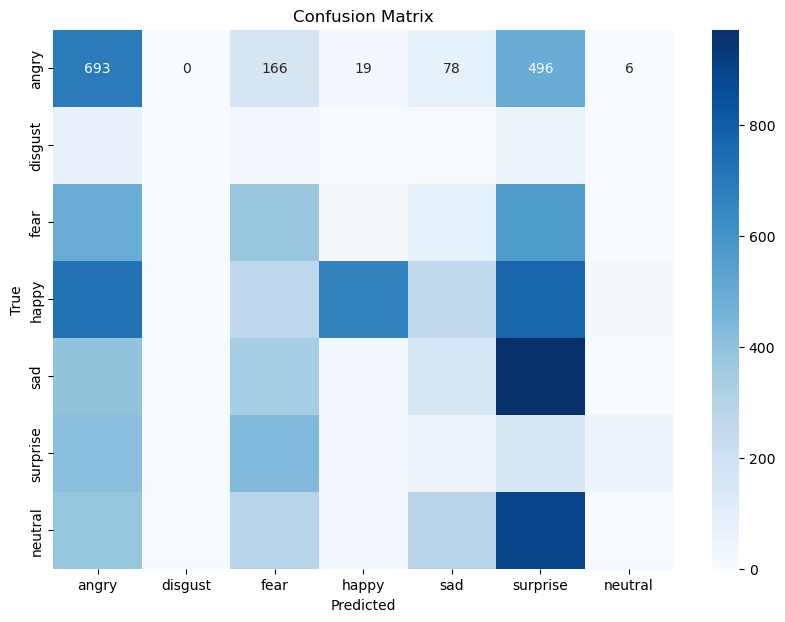

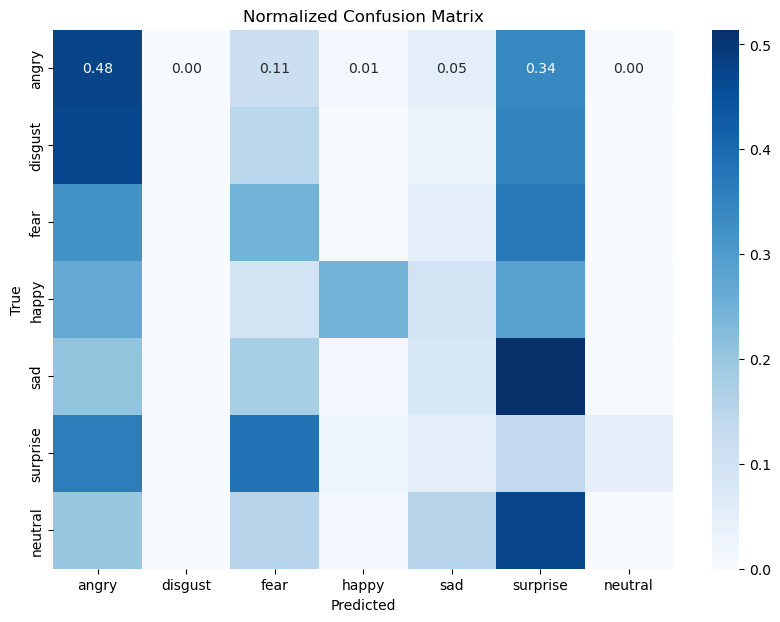

Image shape: (48, 48)


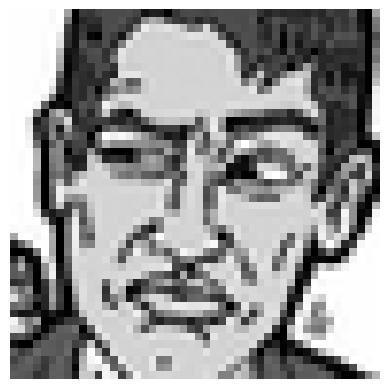

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Predicted emotion: angry


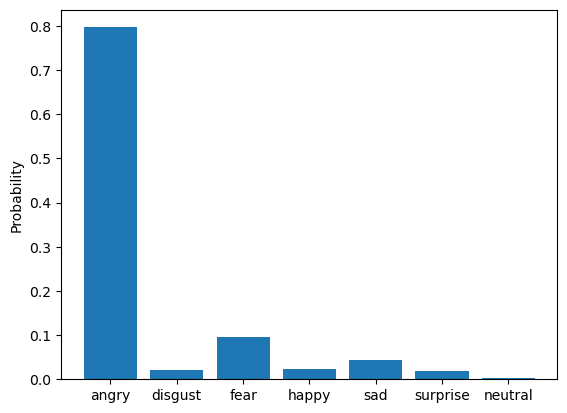

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


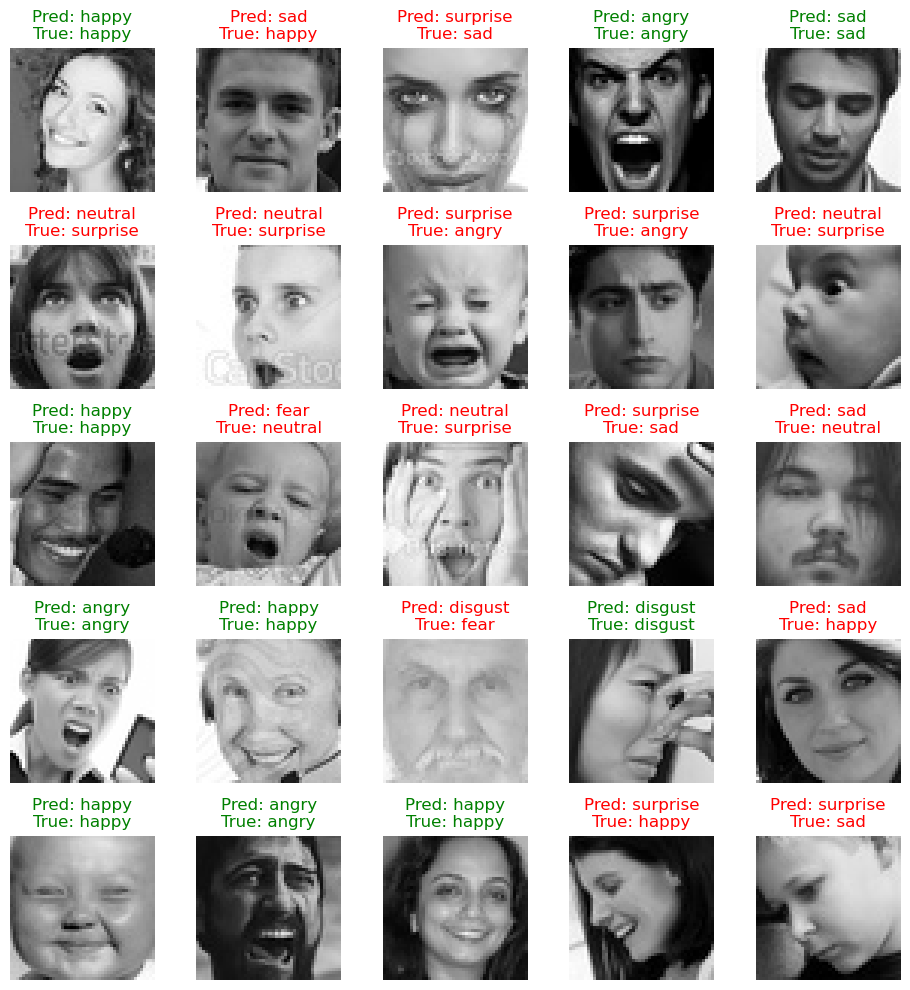

In [30]:
# if history is not None:

#     # PLOT TRAINING AND VALIDATION ACCURACY
#     plt.plot(history.history['accuracy'], label='accuracy')
#     plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#     plt.show()

#     # PLOT TRAINING AND VALIDATION LOSS
#     plt.plot(history.history['loss'], label='loss')
#     plt.plot(history.history['val_loss'], label = 'val_loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#     plt.show()
    
#     # Zugreifen auf die Metriken im Trainingsverlauf
#     accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']

#     # Beispielausgabe der Genauigkeit
#     print("Training Accuracy:", accuracy)
#     print("Validation Accuracy:", val_accuracy)


# SAVE MODEL, if model is defined

if model is not None: 
    model.save(modelName + '.keras')
    print('Model saved.')
else:
    # Load model
    model = tf.keras.models.load_model(modelName + '.keras')
    print('Model loaded.')

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
evaluation = model.evaluate(x_test, y_test_encoded)

# Evaluationsergebnisse anzeigen
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# TEST MODEL
# Load test image
file_path = 'dataset/test/angry/PrivateTest_88305.jpg'
img = x_test[0]
print(f'Image shape: {img.shape}')

# Display image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

img = np.reshape(img, [1, 48, 48, 1])
img = img / 255.0  # Normalize to [0, 1]
# Predict emotion
prediction = model.predict(img)
emotion = classes[np.argmax(prediction)]
print(f'Predicted emotion: {emotion}')

# Display prediction
plt.bar(classes, prediction[0])
plt.ylabel('Probability')
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    img = img / 255.0  # Normalize to [0, 1]
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = 'g' if emotion == true_emotion else 'r'
    plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))
    plt.title(f'Pred: {emotion}\nTrue: {true_emotion}', color=color)
    plt.axis('off')
    plt.tight_layout()
    
plt.show()